# Problem statement

https://www.sciencedirect.com/science/article/pii/S0021999118307125

\begin{equation}
    \begin{aligned}
        u_t +uu_{x}&=\frac{0.01}{\pi}u_{xx},\\ 
        u(0,x)&=-sin(\pi x),\\
        u(t,-1)&=u(t,1)=0\\
\end{aligned}
\end{equation}
 $\text{where, } x \in [-1,1] \text{ and } t \in [0,1]$.

# imports

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from random import uniform
import pickle
import  FINDER_core as FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# PINN class

In [3]:
class BurgersPINN(nn.Module):
    def __init__(self, X_f):
        super(BurgersPINN, self).__init__()

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1)).to(device)

        # initialize net:
        self.create_net()
        
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).detach().clone().to(device) # set same initial point to both optimizers
                                                         
        """allocating memory to variables to reduce load on garbage collection"""
        self.grads = torch.zeros_like(self.start) # gradients w.r.t model parameters
        
        # MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)).to(device)


    def forward(self, x, t):
        u = t * (x**2 - 1) * self.net( torch.hstack((x, t)) ) - torch.sin(torch.pi * x)
        return u

    def net_f(self, x, t):
        u = self(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f
        
    def plot(self):
        """ plot the solution on new data """
        
        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow', 
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        
        '''
        constructing xmean to match the shape of parameter in model.parameters
        '''
        torch.nn.utils.vector_to_parameters(param, self.net.parameters())
    
        '''
        loss
        '''
        # reset gradients to zero:
        self.zero_grad()
        
        # u & f predictions:
        f_prediction = self.net_f(self.x_f, self.t_f)
        if no_grad == False:
            # losses:
            self.ls = self.loss(f_prediction, self.null)
            
            '''
            backward pass
            '''
        
            self.ls.backward()
        
            '''
            grads
            '''
            self.grads[:] = torch.nn.utils.parameters_to_vector([param.grad for param in self.parameters()])
            
            return self.ls.detach().item(), self.grads
        else:
            with torch.no_grad():
                
                self.ls = self.loss(f_prediction, self.null)
                
                return self.ls.detach().item()

    def closure(self):
        self.zero_grad()
        
        f_prediction = self.net_f(self.x_f, self.t_f)
    
        # losses:
        self.ls = self.loss(f_prediction, self.null)

        self.ls.backward()
        return self.ls

# Datapoints, constants

In [4]:
nu = 0.01 / torch.pi         # constant in the diff. equation

In [5]:
a = np.linspace(-1,1, 100)
# a = a[1:-1]
b = np.linspace(0,1, 100)
# b = b[1:-1]
x,t = np.meshgrid(a,b)
x = x.flatten()
t = t.flatten()
X_f_train = np.vstack([x,t]).T

In [6]:
X_f_train.shape

(10000, 2)

# model

In [7]:
# pass data sets to the PINN:
pinn = BurgersPINN(X_f_train)

In [8]:
start = torch.nn.utils.parameters_to_vector(pinn.parameters()).detach().clone()

In [9]:
start.shape

torch.Size([20601])

# training with Adam

In [10]:
every = 100
fx_adam = []
torch.nn.utils.vector_to_parameters(start.clone(), pinn.parameters())
Adam = torch.optim.Adam(pinn.parameters(), lr=1e-3)
pinn.train()
tic = time.time()
for epoch in range(100000):
    loss_value = pinn.loss_grad(torch.nn.utils.parameters_to_vector(pinn.parameters()), 
                                inputs=None, no_grad=False)[0]
    Adam.step()
    if epoch % every == 0:
        print(f'Epoch [{epoch}] loss: {loss_value:.6f}')
    fx_adam.append(loss_value)
    if loss_value < 1e-3:
        break
toc = time.time()
runtime_adam = round(toc - tic)
print(toc - tic)

Epoch [0] loss: 1.225004
Epoch [100] loss: 0.423072
Epoch [200] loss: 0.394521
Epoch [300] loss: 0.367409
Epoch [400] loss: 0.306706
Epoch [500] loss: 0.281781
Epoch [600] loss: 0.269044
Epoch [700] loss: 0.238489
Epoch [800] loss: 0.230141
Epoch [900] loss: 0.221163
Epoch [1000] loss: 0.226895
Epoch [1100] loss: 0.190548
Epoch [1200] loss: 0.201446
Epoch [1300] loss: 0.147277
Epoch [1400] loss: 0.094750
Epoch [1500] loss: 0.095121
Epoch [1600] loss: 0.096633
Epoch [1700] loss: 0.063821
Epoch [1800] loss: 0.043279
Epoch [1900] loss: 0.041608
Epoch [2000] loss: 0.035783
Epoch [2100] loss: 0.033381
Epoch [2200] loss: 0.031495
Epoch [2300] loss: 0.030752
Epoch [2400] loss: 0.037649
Epoch [2500] loss: 0.050510
Epoch [2600] loss: 0.034607
Epoch [2700] loss: 0.025111
Epoch [2800] loss: 0.046268
Epoch [2900] loss: 0.024217
Epoch [3000] loss: 0.021137
Epoch [3100] loss: 0.032485
Epoch [3200] loss: 0.020183
Epoch [3300] loss: 1.345206
Epoch [3400] loss: 0.067021
Epoch [3500] loss: 0.030789
Epoc

# training loop with LBFGS with line search

In [11]:
fx_LBFGS = []
torch.nn.utils.vector_to_parameters(start.clone(), pinn.net.parameters())
LBFGS = torch.optim.LBFGS(pinn.parameters(), lr = 1, line_search_fn='strong_wolfe')
pinn.train()
tic = time.time()
for epoch in range(2000):
    loss_value = LBFGS.step(closure = pinn.closure)
    print(f'Epoch [{epoch}] loss: {loss_value:.6f}')
    fx_LBFGS.append(loss_value.item())
    if loss_value < 1e-3:
        break
toc = time.time()
runtime_lbfgs = round(toc - tic)
print(toc - tic)

Epoch [0] loss: 1.225004
Epoch [1] loss: 0.447404
Epoch [2] loss: 0.412432
Epoch [3] loss: 0.398996
Epoch [4] loss: 0.395164
Epoch [5] loss: 0.390350
Epoch [6] loss: 0.382616
Epoch [7] loss: 0.374795
Epoch [8] loss: 0.365714
Epoch [9] loss: 0.359904
Epoch [10] loss: 0.350797
Epoch [11] loss: 0.338489
Epoch [12] loss: 0.320885
Epoch [13] loss: 0.295789
Epoch [14] loss: 0.285715
Epoch [15] loss: 0.280728
Epoch [16] loss: 0.270547
Epoch [17] loss: 0.267388
Epoch [18] loss: 0.262408
Epoch [19] loss: 0.258942
Epoch [20] loss: 0.256494
Epoch [21] loss: 0.253824
Epoch [22] loss: 0.252073
Epoch [23] loss: 0.247473
Epoch [24] loss: 0.246519
Epoch [25] loss: 0.245009
Epoch [26] loss: 0.243487
Epoch [27] loss: 0.242318
Epoch [28] loss: 0.241847
Epoch [29] loss: 0.241087
Epoch [30] loss: 0.238691
Epoch [31] loss: 0.238182
Epoch [32] loss: 0.237515
Epoch [33] loss: 0.235300
Epoch [34] loss: 0.234312
Epoch [35] loss: 0.233030
Epoch [36] loss: 0.230449
Epoch [37] loss: 0.229487
Epoch [38] loss: 0.227

# train loop with FINDER

In [12]:
torch.nn.utils.vector_to_parameters(start.clone(), pinn.parameters())
FINDER = FINDER_core.FINDER(model=pinn, line_search="backtracking")

In [13]:
fx = []
every = 100
epochs = 10000
pinn.train()
tic1 = time.time()
for epoch in range(epochs):
    loss_value = FINDER.step(inputs=None)
    if epoch % every ==0 or epoch == epochs -1:
        print(f'Epoch [{epoch}] loss: {loss_value:.6f}')
    fx.append(loss_value)
    if loss_value < 1e-3:
        break
toc1 = time.time()
runtime_FINDER = round(toc1 - tic1)
print(toc1 - tic1)

Epoch [0] loss: 1.158931
Epoch [100] loss: 0.259274
Epoch [200] loss: 0.052607
Epoch [300] loss: 0.024090
Epoch [400] loss: 0.009809
Epoch [500] loss: 0.004641
Epoch [600] loss: 0.002808
Epoch [700] loss: 0.001676
Epoch [800] loss: 0.001039
167.50736260414124


# plotting

In [17]:
fx.insert(0,fx_adam[0])

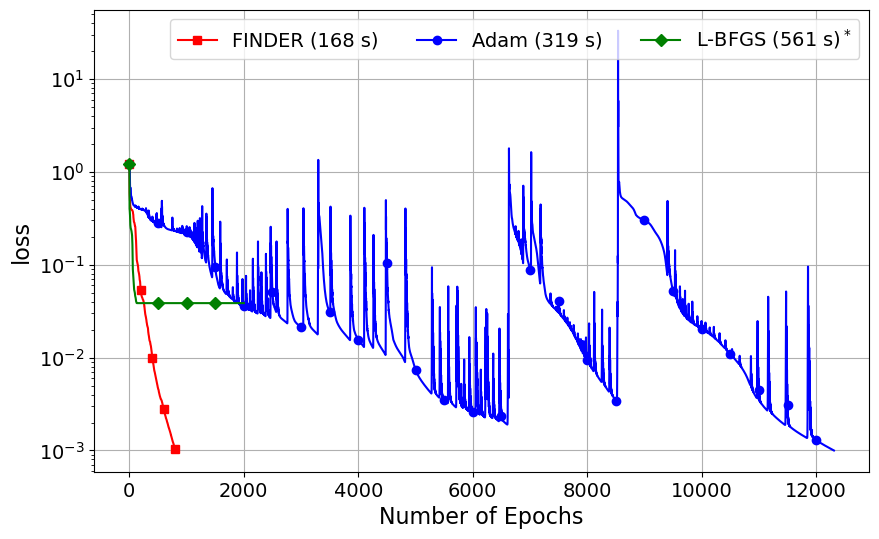

In [18]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()


plt.plot(fx, 'rs-', markevery= 200, label=f"FINDER ({runtime_FINDER} s)")
plt.plot(fx_adam, 'bo-', markevery= 500, label=f"Adam ({runtime_adam} s)")
plt.plot(fx_LBFGS, 'gD-', markevery= 500, label=f"L-BFGS ({runtime_lbfgs} s)$^*$")

plt.ylabel('loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.legend(loc="best", ncol=3, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()

# save data

In [19]:
torch.save(torch.tensor(fx_adam), f'PlotData/Burgers/Burgers_Adam_N20601_{runtime_adam}s.pt')

In [20]:
torch.save(torch.tensor(fx_LBFGS), f'PlotData/Burgers/Burgers_LBFGS_N20601_{runtime_lbfgs}s.pt')

In [21]:
torch.save(torch.tensor(fx), f'PlotData/Burgers/Burgers_FINDER_N20601_{runtime_FINDER}s.pt')

# testing with FINDER

/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


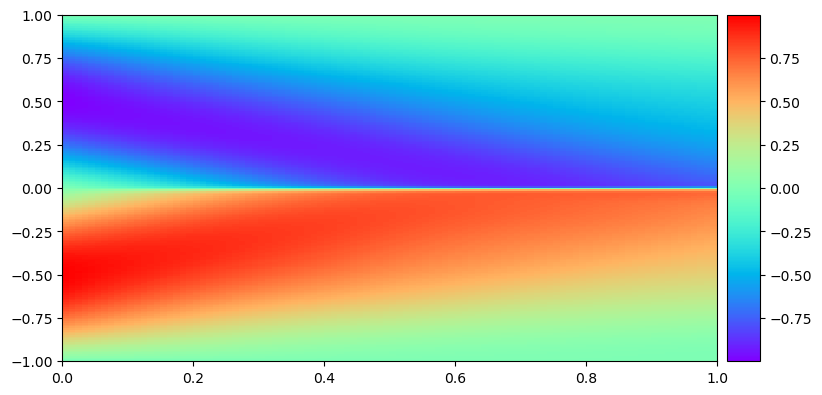

In [22]:
pinn.cpu().plot()